In [72]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
#preprocessing


def checkSpikeLocations():
    gt = scipy.io.loadmat('../data/gen/ground_truth.mat')
    sim = scipy.io.loadmat('../data/gen/simulation_1.mat')
    print(gt["spike_first_sample"][0][0].shape)
    print(gt["su_waveforms"][0][0].shape)
    print(gt["spike_classes"][0][0].shape)


    print(gt["spike_first_sample"][0][0][0][0])
    print(gt["spike_classes"][0][0][0][1])

    first_spike_start = gt["spike_first_sample"][0][0][0][0]
    first_spike_class = gt["spike_classes"][0][0][0][1]

    data = sim["data"][0][first_spike_start : first_spike_start + 80]

    waveform = gt["su_waveforms"][0][0][first_spike_class]

    fig, axs = plt.subplots(2)
    fig.suptitle('Single unit waveform vs. Simulated signal')
    axs[0].plot(range(0,316), waveform)
    axs[1].plot(range(0,80), data)

    plt.show()

def splitSim(simNo):
    gt = scipy.io.loadmat('../data/gen/ground_truth.mat')
    sim = scipy.io.loadmat('../data/gen/simulation_{}.mat'.format(simNo))

    data = sim["data"][0]
    firstSamples = gt["spike_first_sample"][0][simNo - 1][0]

    spikes = []
    hash = []

    simIndex = 0
    spikeIndex = 0
    sampleNumber = len(data)
    spikeNumber = len(firstSamples)
    spikeLength = 79 # 316 at 96k Hz downsampled to 24k Hz

    while simIndex < sampleNumber:
        if spikeIndex < spikeNumber: # I still have spikes 
            if simIndex < firstSamples[spikeIndex]: # a non-spike interfal follows
                hash.append(data[simIndex : firstSamples[spikeIndex]])
                simIndex = firstSamples[spikeIndex]
            else: # I have a spike
                spikes.append(data[simIndex : simIndex + spikeLength])
                simIndex += spikeLength
                spikeIndex += 1
        else: # No more spikes; might still have hash
            hash.append(data[simIndex:])
            simIndex = sampleNumber

    return (np.array(spikes), np.array(hash, dtype=object))



In [80]:
#define the models
class DebugLayer(nn.Module):
    def __init__(self, log):
        super(DebugLayer, self).__init__()
        self.log = log
    
    def forward(self, x):
        print(self.log)
        print(x.shape)
        return x
    
class netG(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(netG, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize
        
        self.mainModule = nn.Sequential(
            #DebugLayer("gen input"),
            nn.Linear(self.inputSize, self.hiddenSize, bias=True),
            #DebugLayer("gen first lin"),
            nn.Softplus(),
            #DebugLayer("gen first sf"),
            nn.Linear(self.hiddenSize, self.outputSize, bias=True),
            #DebugLayer("gen second lin"),
            nn.Softplus(),
            #DebugLayer("gen second sf"),
        )
        
    def forward(self, x):
        return self.mainModule(x.view(-1,self.inputSize))


class netD(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(netD, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize

        self.mainModule = nn.Sequential(
            #DebugLayer("disc input"),
            nn.Linear(self.inputSize, self.hiddenSize, bias=True),
            #DebugLayer("disc first lin"),
            nn.Tanh(),
            #DebugLayer("disc tanh"),
            nn.Linear(self.hiddenSize, 1, bias=True),
            #DebugLayer("disc second lin"),
        )
        
    def forward(self, x):
        return self.mainModule(x.view(-1,self.inputSize))

def adversarial_trainer( 
    train_loader, 
    noise_loader,
    generator, 
    discriminator, 
    epochs=5,
    learningRate=0.001,
    criterion=nn.BCELoss(),
    clampLower=-0.01,
    clampHigher=0.01,
    Diters=5,
    Giters=1
):
    inputSize, outputSize = generator.inputSize, generator.outputSize
    
    optimizerD = optim.RMSprop(discriminator.parameters(), lr=learningRate)
    optimizerG = optim.RMSprop(generator.parameters(), lr=learningRate)
    
    my_dpi = 96
    plt.figure(figsize=(1200/my_dpi, 600/my_dpi), dpi=my_dpi)
    true, false = 1, 0
    one = torch.tensor(1, dtype=torch.float)
    mone = one * -1
    
    dRealErr = []
    dFakeErr = []
    gErr = []
    
    for epoch in range(epochs):
        for batch, ([ft], [noise]) in enumerate(zip(train_loader, noise_loader)):
            ft = ft.squeeze().to(device)
            noise = noise.to(device)

            for disc_ep in range(Diters):
                for p in discriminator.parameters():
                    p.data.clamp_(clampLower, 
                                  clampHigher)


                # discriminator gradient with real data
                discriminator.zero_grad()
                out_d = discriminator.forward(ft)

                err_D_real = out_d.mean()
                dRealErr.append(err_D_real.cpu().detach().numpy())
                err_D_real.backward(one)

                # discriminator gradient with generated data
                
                out_g = generator.forward(noise)
                out_d_g = discriminator.forward(Variable(out_g.data))
                err_D_fake = out_d_g.mean()
                dFakeErr.append(err_D_fake.cpu().detach().numpy())
                err_D_fake.backward(mone)

                err_D = err_D_real - err_D_fake
                optimizerD.step()

            # generator gradient
            for gEpoch in range(Giters):
                generator.zero_grad()
                out_h_data = discriminator.forward(ft)    
                out_h_g = discriminator.forward(out_g) 
                #err_G = ((out_h_data.mean(0) - out_h_g.mean(0))**2).sum()
                err_G = torch.mean(out_h_g)
                gErr.append(err_G.cpu().detach().numpy())
                err_G.backward()

                optimizerG.step()

        # show the current generated output
        if (epoch + 1) % 5 == 0:
            fig, axs = plt.subplots(3)
            axs[0].plot(dRealErr)
            axs[1].plot(dFakeErr)
            axs[2].plot(gErr)

            plt.show()

            print("out_d {}".format(out_d.mean()))
            print("out_d_g {}".format(out_d_g.mean()))
            print("err_G {}".format(err_G.mean()))
            print("Epoch {}".format(epoch))

In [69]:
def gen_loaders(L1, batchsize, simNo):
    sim = scipy.io.loadmat('../data/gen/simulation_{}.mat'.format(simNo))
    data = sim["data"][0]
    
    spikes, bg = splitSim(simNo)
    
    background = []
    
    for chunk in bg:
        i = 0
        sample = []
        while i < len(chunk):
            sample.append(chunk[i])
            i += 1
            if i % 79 == 0:
                background.append(sample)
                sample = []
                
    background = np.array(background)

    
    n1 = torch.randn(len(spikes), L1) 
    n2 = torch.randn(len(background), L1) 
    n1 = data_utils.TensorDataset(n1)
    n2 = data_utils.TensorDataset(n2)  
    
    spikes = torch.from_numpy(spikes).float()
    background = torch.from_numpy(background).float()
    data = torch.from_numpy(data).float()
    
    sim_dataset        = data_utils.TensorDataset(data)
    spike_dataset      = data_utils.TensorDataset(spikes)
    background_dataset = data_utils.TensorDataset(background)
    
    noise1 = data_utils.DataLoader(n1, batch_size=batchsize, shuffle=False)
    noise2 = data_utils.DataLoader(n2, batch_size=batchsize, shuffle=False)
    loader1 = data_utils.DataLoader(spike_dataset, batch_size=batchsize, shuffle=False)
    loader2 = data_utils.DataLoader(background_dataset, batch_size=batchsize, shuffle=False)
    loader_mix = data_utils.DataLoader(sim_dataset, batch_size=batchsize, shuffle=False)

    return noise1, noise2, loader1, loader2, loader_mix

In [70]:
batchSize = 1000
simNo = 1
noise1, noise2, loader1, loader2, loader_mix  = gen_loaders(
    200, batchSize, simNo)

<Figure size 1200x600 with 0 Axes>

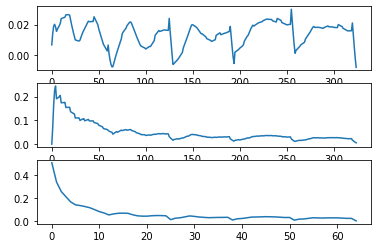

out_d -0.007995731197297573
out_d_g 0.0064261797815561295
err_G 0.0033984296023845673
Epoch 4


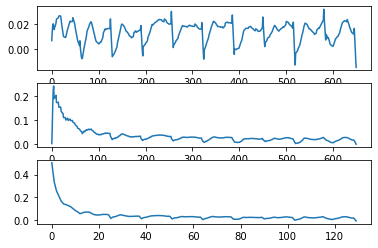

out_d -0.014568932354450226
out_d_g -0.0017462953692302108
err_G -0.007791448384523392
Epoch 9


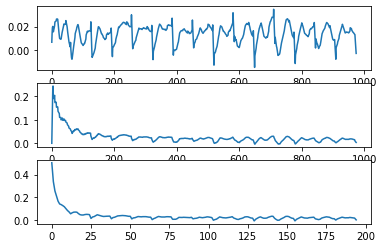

out_d -0.002698965137824416
out_d_g 0.004576671868562698
err_G 0.001281897770240903
Epoch 14


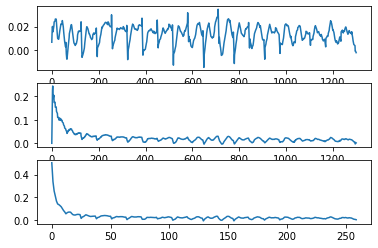

out_d -0.002074914053082466
out_d_g 0.0025067038368433714
err_G 0.0027082839515060186
Epoch 19


<Figure size 1200x600 with 0 Axes>

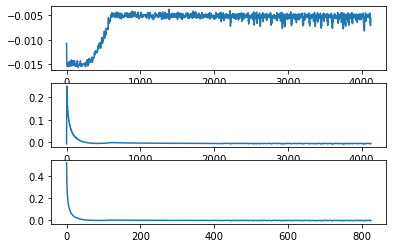

out_d -0.005719075910747051
out_d_g -0.005000791512429714
err_G -0.0033283582888543606
Epoch 4


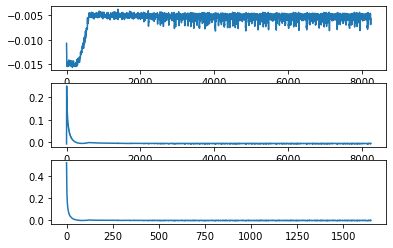

out_d -0.005758412182331085
out_d_g -0.005001905374228954
err_G -0.003168433206155896
Epoch 9


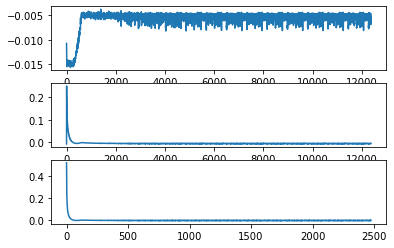

out_d -0.005760354921221733
out_d_g -0.005001969635486603
err_G -0.003169449046254158
Epoch 14


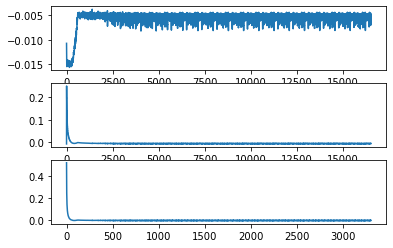

out_d -0.005738802719861269
out_d_g -0.005002334248274565
err_G -0.003238318720832467
Epoch 19


In [81]:
gen1 = netG(inputSize=200, hiddenSize=50, outputSize=79).to(device)
disc1 = netD(inputSize=79, hiddenSize=50).to(device)
gen2 = netG(inputSize=200, hiddenSize=50, outputSize=79).to(device)
disc2 = netD(inputSize=79, hiddenSize=50).to(device)

adversarial_trainer( 
    train_loader=loader1, 
    noise_loader=noise1,
    generator=gen1, 
    discriminator=disc1, 
    epochs=5 0,
    learningRate=0.001,
    criterion=nn.BCELoss()
)

adversarial_trainer( 
    train_loader=loader2, 
    noise_loader=noise2,
    generator=gen2, 
    discriminator=disc2, 
    epochs=20,
    learningRate=0.001,
    criterion=nn.BCELoss()
)